# Looping Graph

- We will implement looping logic to route the flow of data back to the nodes
- Creating a single conditional edge to handle the decision making and control the graph flow

```mermaid
    flowchart LR
    START --> A[Greeting Node]
    A[Greeting Node] --> B[Random Node]
    B[Random Node] --> END
    B[Random Node] --LOOP!--> B[Random Node]
```

In [37]:
from langgraph.graph import StateGraph, START, END
import random
from typing import TypedDict, List, Dict

In [38]:
class AgentState(TypedDict):
    name: str
    numbers: List[int]
    counter: int

In [39]:
def greeting_node(state:AgentState) -> AgentState:
    """ greets the person with a hi, just updates the name key"""
    
    state['name'] = "Hi there, " + state['name']
    state['counter'] = 0

    return state

def random_node(state:AgentState) -> AgentState:
    """Generates a random number from 0 to 10"""
    
    state['numbers'].append(random.randint(0,10))
    state['counter'] += 1
    
    return state

Now, we add a conditional edge to loop

In [40]:
def should_continue(state:AgentState) -> AgentState:
    """Function decides what to do next"""
    
    if state['counter'] <= 5:
        print("ENETERING LOOP, "+ str(state['counter']))
        return "loop" # continue looping
    else:
        return "exit" # exit the loop

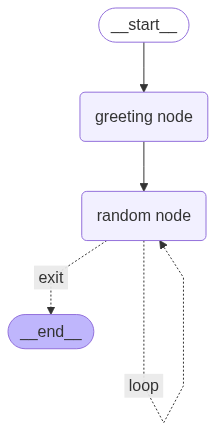

In [41]:
graph = StateGraph(AgentState)

graph.add_node("greeting node", greeting_node)
graph.add_node("random node", random_node)

graph.add_edge(START, "greeting node")
graph.add_edge("greeting node", "random node")
graph.add_conditional_edges(
    "random node", # source node
    should_continue, # Action
    {
        "loop": "random node", # self loop back to same node
        "exit": END # if exit then go to next (END) node
    }
)

app = graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [42]:
result = app.invoke({'name':"Dhruv", 'numbers':[], 'counter':-10})
result

ENETERING LOOP, 1
ENETERING LOOP, 2
ENETERING LOOP, 3
ENETERING LOOP, 4
ENETERING LOOP, 5


{'name': 'Hi there, Dhruv', 'numbers': [9, 8, 2, 9, 9, 9], 'counter': 6}

## Task: Automatic Higher or Lower Game
- set bounds between 1 and 20, game has to keep guessing (max guesses: 7) until its correct.
- if its correct, game stops but if its not we keep looping till max limit of 7 is reached.
- each time a number is guessed, the hint node will say higher or lower accordingly and the graph should account for this info and provide the next guess.
- input parameters: {'player_name':"Student", 'guesses':[], 'attempts':0, 'lower_bound':1, 'upper_bound':20}

```mermaid
    flowchart LR
    START --> A[greeting and setup node]
    A[greeting and setup node] --> B[guessing node]
    B[guessing node] --> C[hint node]
    C[hint node] --continue--> B[guessing node]
    C[hint node] --> END
```

In [47]:
class AgentState(TypedDict):
    player_name:str
    guesses: List[int]
    attempts: int
    lower_bound: int
    upper_bound: int
    target: int
    hint: str

In [58]:
def greeting_node(state:AgentState) -> AgentState:
    """greets the person and sets up a target between 1 and 20"""
    
    state['player_name'] = f"Hi there, {state['player_name']}!"
    print(state['player_name'])
    
    state['attempts'] = 0
    state['lower_bound'] = 1; state['upper_bound'] = 20
    state['target'] = random.randint(state['lower_bound'],state['upper_bound'])
    
    return state

def guessing_node(state:AgentState) -> AgentState:
    """machine guesses something out of the current lower and upper bounds"""
    
    state['guesses'].append(random.randint(state['lower_bound'],state['upper_bound']))
    state['attempts'] += 1
    print("Attempt: " + str(state['attempts']))
    
    return state
    
def hint_node(state:AgentState) -> AgentState:
    """hint node tells if the target is lower or higher than the last guess and determines what to do next based on number of attempts"""
    
    if (state['guesses'][-1] == state['target']) and (state['attempts'] < 7):
        state["hint"] = f"Correct! You found the number {state['target']} in {state['attempts']} attempts."
        print("You're right! You win! The correct guess was: " + str(state['target']))
    elif (state['guesses'][-1] > state['target']) and (state['attempts'] < 7):
        print(f"Guess: {state['guesses'][-1]} is too high, try lower.")
        state["hint"] = f"The number {state['guesses'][-1]} is too high. Try lower!"
        state['upper_bound'] = min(state['upper_bound'], state['guesses'][-1]-1)
    else:
        print(f"Guess: {state['guesses'][-1]} is too low, try higher.")
        state["hint"] = f"The number {state['guesses'][-1]} is too low. Try higher!"
        state['lower_bound'] = max(state['lower_bound'], state['guesses'][-1] + 1)

    return state

def should_continue(state:AgentState) -> str:
    """determines if we should contine the game or not"""
    
    # There are 2 end conditions - either 7 is reached or the correct number is guessed
    
    if state["guesses"][-1] == state['target']:
        print(f"GAME OVER: Number found!")
        return "end"
    elif state["attempts"] >= 7:
        print(f"GAME OVER: Maximum attempts reached! The number was {state['target_number']}")
        return "end"
    else:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        return "continue"
    

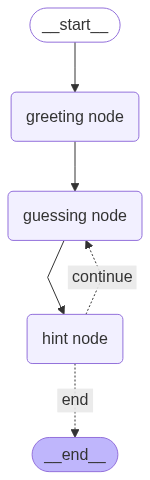

In [59]:
graph = StateGraph(AgentState)

graph.add_node("greeting node", greeting_node)
graph.add_node("guessing node", guessing_node)
graph.add_node("hint node", hint_node)

graph.add_edge(START, "greeting node")
graph.add_edge("greeting node", "guessing node")
graph.add_edge("guessing node", "hint node")

graph.add_conditional_edges(
    "hint node",
    should_continue,
    {
        "end": END,
        "continue": "guessing node"
    }
)

app = graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [60]:
results = app.invoke({"player_name": "Dhruv", "guesses": [], "attempts": 0, "lower_bound": 1, "upper_bound": 20})

Hi there, Dhruv!
Attempt: 1
Guess: 20 is too high, try lower.
CONTINUING: 1/7 attempts used
Attempt: 2
Guess: 15 is too high, try lower.
CONTINUING: 2/7 attempts used
Attempt: 3
Guess: 1 is too low, try higher.
CONTINUING: 3/7 attempts used
Attempt: 4
Guess: 4 is too low, try higher.
CONTINUING: 4/7 attempts used
Attempt: 5
You're right! You win! The correct guess was: 6
GAME OVER: Number found!
